In [2]:
import pandas as pd
import torch
import numpy as np
import nltk

from transformers import BertTokenizer, BertModel
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertModel


In [11]:
#upload 2 files with correct answers and the answers provideed by our proposed model
modelAnswers_df = pd.read_csv('answer_model.csv') #enter the path for proposedAnswers
adf = pd.read_csv('answers.csv') #enter the path for correct answers

In [12]:
modelAnswers_df.head()

,Question,Answer,eval
0,What are the most common crimes mentioned in t...,"Based on the data provided, it appears that th...",NaN
1,"Which case had the highest fine, and what was ...","Based on the information provided, the case th...",NaN
2,How many cases involved insider trading in 2011?,Based on the structured information from the g...,NaN
3,What types of actions were taken against viola...,"Dear user, my analysis shows that there were f...",NaN
4,Who were the violators in cases involving frau...,"To answer this question, I will use the unstru...",NaN


In [13]:
# Download the list of stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    """
    Remove stop words from a string.

    Args:
    text (str): The input string.

    Returns:
    str: The string with stop words removed.
    """
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

def calculate_bert_semantic_accuracy(model_answers, correct_answers):
    """
    Calculate the accuracy of a model based on semantic similarity between the model's answers and the correct answers,
    using BERT for tokenization and embedding generation.

    Args:
    model_answers (list of str): The answers provided by the model.
    correct_answers (list of str): The correct answers for the questions.

    Returns:
    float: The semantic accuracy of the model.
    """
    # Load pre-trained BERT model and tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    # Tokenize and encode the sequences
    def encode(answers):
        answers = [remove_stopwords(answer) for answer in answers]
        tokens = tokenizer(answers, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            embeddings = model(**tokens).last_hidden_state.mean(dim=1)
        return embeddings

    # Compute embeddings
    model_answer_embeddings = encode(model_answers)
    correct_answer_embeddings = encode(correct_answers)

    # Calculate cosine similarities
    similarities = torch.nn.functional.cosine_similarity(model_answer_embeddings, correct_answer_embeddings)


    return similarities
model_answers = []  # Replace with the answers from your model
correct_answers = []  # Replace with the correct answers from your dataset

n = min(modelAnswers_df.shape[0],adf.shape[0])
for i in range(34):
  model_answers.append(modelAnswers_df['Answer'][i])
  correct_answers.append(str(adf['Answers'][i]))



bert_semantic_accuracy = calculate_bert_semantic_accuracy(model_answers, correct_answers)
print(f"Model BERT Semantic Accuracy: {bert_semantic_accuracy }")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model BERT Semantic Accuracy: tensor([0.8291, 0.8492, 0.5920, 0.8306, 0.6011, 0.8456, 0.7202, 0.6505, 0.8165,
        0.7498, 0.7418, 0.8319, 0.6278, 0.6186, 0.7563, 0.6948, 0.7571, 0.6970,
        0.7549, 0.6915, 0.6960, 0.6771, 0.7719, 0.7977, 0.5963, 0.8179, 0.7039,
        0.6697, 0.7221, 0.7670, 0.7484, 0.7622, 0.6513, 0.7339])


In [14]:
print(len(bert_semantic_accuracy))

34


In [15]:
from statistics import mean
def calculate_avg(model):

  return mean(model.tolist())

print(f"Average semantic accuracy is: {calculate_avg(bert_semantic_accuracy)}")

Average semantic accuracy is: 0.7285827924223507


In [16]:
def approximate_precision(similarity_scores, threshold):
    """
    Approximate the precision of answers based on similarity scores and a defined threshold.

    Args:
    similarity_scores (list): A list of similarity scores.
    threshold (float): The threshold for considering an answer as a positive prediction.

    Returns:
    float: The approximate precision as a percentage.
    """
    aTP = sum(score >= threshold for score in similarity_scores)
    aFP = sum(score < threshold for score in similarity_scores)  # This is a rough approximation

    if aTP + aFP == 0:
        return 0

    approx_precision = (aTP / (aTP + aFP)) * 100
    return approx_precision

similarity_scores = bert_semantic_accuracy.tolist()  # similarity scores
threshold = 0.7  # Threshold for considering an answer as a positive prediction

precision = approximate_precision(similarity_scores, threshold)
print(f"Precision of our method is {precision}")


Precision of our method is 61.76470588235294


In [17]:
def approximate_recall(similarity_scores, threshold, estimated_total_positives):
    """
    Approximate the recall of answers based on similarity scores, a defined threshold, and an estimated total number of positives.

    Args:
    similarity_scores (list): A list of similarity scores.
    threshold (float): The threshold for considering an answer as a retrieved positive.
    estimated_total_positives (int): An estimate of the total number of correct answers in the dataset.

    Returns:
    float: The approximate recall as a percentage.
    """
    aTP = sum(score >= threshold for score in similarity_scores)

    if estimated_total_positives == 0:
        return 0

    approx_recall = (aTP / estimated_total_positives) * 100
    return approx_recall

# Example usage
similarity_scores = bert_semantic_accuracy.tolist()  # Example similarity scores
threshold = 0.7  # Threshold for considering an answer as a retrieved positive
estimated_total_positives = 30  # An estimated total number of correct answers

recall = approximate_recall(similarity_scores, threshold, estimated_total_positives)
print(f"Recall of our method is {recall}")

Recall of our method is 70.0


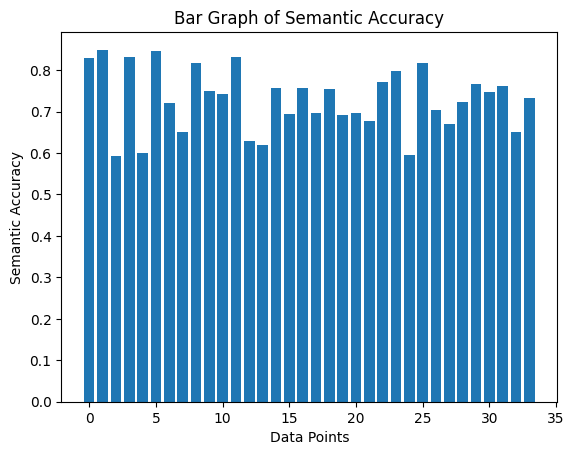

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

data_series = bert_semantic_accuracy

# Create a bar graph
plt.bar(range(len(data_series)), data_series)

# Set labels and title
plt.xlabel('Data Points')
plt.ylabel('Semantic Accuracy')
plt.title('Bar Graph of Semantic Accuracy')

# Display the bar graph
plt.show()

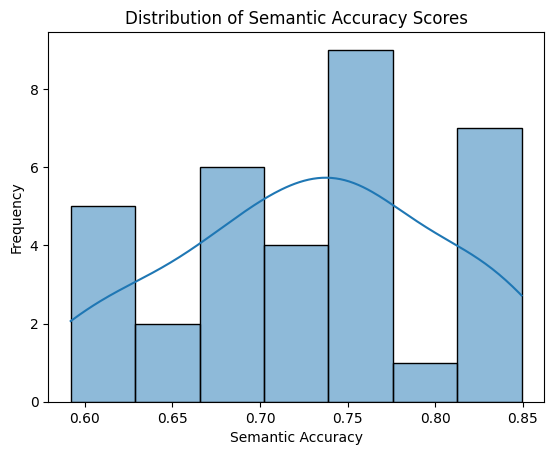

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(bert_semantic_accuracy, kde=True)
plt.title('Distribution of Semantic Accuracy Scores')
plt.xlabel('Semantic Accuracy')
plt.ylabel('Frequency')
plt.show()

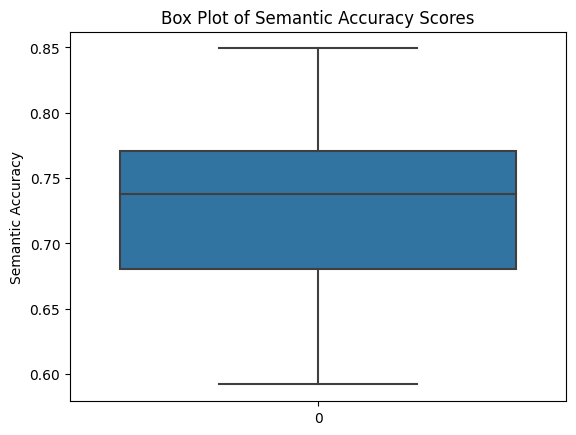

In [20]:
sns.boxplot(bert_semantic_accuracy.tolist())
plt.title('Box Plot of Semantic Accuracy Scores')
plt.ylabel('Semantic Accuracy')
plt.show()

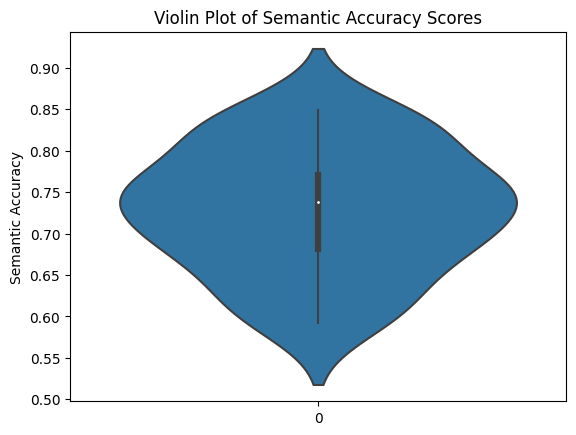

In [21]:
sns.violinplot(bert_semantic_accuracy.tolist())
plt.title('Violin Plot of Semantic Accuracy Scores')
plt.ylabel('Semantic Accuracy')
plt.show()


###Human Evaluations

We did human evaluations on 36 questions using 5 human evaluators. The answers provided by llm was judged against the correct answers and was ranked on a scale of 1 to 5 with 5 being perfectly matching and 1 meaning irrelevant answer.\
Following are the results found:
- 70% of the responses generated by the model were accurate
- 17% of the responses generated by the model were moderately accurate
- 13% of the responses generated by the model were not entirely accurate